# Кластеризация отзывов, поступивших через виджет обратной связи АИС "Мониторинг Госcайтов" в 2015 г.

В данной заметке выделяется категория проблем, после чего проводится их кластеризация с визуализацией результатов, затем кластеры сохраняются в CSV файл.

Ссылка на набор данных: https://data.gov.ru/opendata/7710349494-gosmonitor-review

Выключаем скроллинг, чтобы было удобнее смотреть результат

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Импортируем необходимые библиотеки

In [2]:
import logging
import logging.config
import os
import wget
import gc
import numpy as np
import pandas as pd

In [3]:
from ComplaintAnalizer import Clustering
from ComplaintAnalizer import clear_classes
from ComplaintAnalizer import clear_clusters

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Настраиваем логгер

In [4]:
logging.config.fileConfig('resources/logging.conf')
logger = logging.getLogger("feedback-analyzer.clustering")

Скачиваем набор данных, с которым будем в дальнейшем работать

In [5]:
url = 'https://data.gov.ru/opendata/7710349494-gosmonitor-review/data-20150923T1145-structure-20150923T1145.csv?encoding=UTF-8'
res = wget.download(url, 'datasets/clustering')

100% [........................................................................] 20892640 / 20892640

In [6]:
print('Downloaded file: ' + res)

Downloaded file: datasets/clustering/data-20150923T1145-structure-20150923T1145.csv


Читаем скаченный набор данных и фильтруем по категории "Проблема"

In [7]:
logger.info('+-----------------------+')
logger.info('| Let\'s go clustering!  |')
logger.info('+-----------------------+')

dataset = pd.read_csv(os.path.abspath(res), header=None).values

logger.info('Complete reading dataset')

2019-10-19 22:53:23,430 - feedback-analyzer.clustering - INFO - +-----------------------+
2019-10-19 22:53:23,435 - feedback-analyzer.clustering - INFO - | Let's go clustering!  |
2019-10-19 22:53:23,438 - feedback-analyzer.clustering - INFO - +-----------------------+
2019-10-19 22:53:24,022 - feedback-analyzer.clustering - INFO - Complete reading dataset


In [8]:
filtered_dataset = []
for i in range(len(dataset)):
    if pd.isnull(dataset[i][8]) or dataset[i][7] != 'Проблема':
        continue
    
    filtered_dataset.append(dataset[i])

dataset = np.array(filtered_dataset)

del filtered_dataset
gc.collect()

logger.info('Complete filtering dataset')

2019-10-19 22:53:24,220 - feedback-analyzer.clustering - INFO - Complete filtering dataset


Создаем экземпляр класса и проводим настройки (очищаем БД, загружаем специальный набор стоп слов)

In [9]:
cl = Clustering(max_features=250,
                msg_column=8,
                min_msg_length=20)

cl.stopwords_from_file('resources/complaint_stopwords.txt')

clear_clusters()
clear_classes()


2019-10-19 22:53:24,235 - feedback-analyzer.ComplaintAnalizer - INFO - Added 349 stop words
2019-10-19 22:53:24,385 - feedback-analyzer.ComplaintAnalizer - INFO - All clusters deleted
2019-10-19 22:53:24,472 - feedback-analyzer.ComplaintAnalizer - INFO - All classes deleted


Проводим уменьшение размерности и кластеризацию текста обращений (PCA + TSNE + HDBSCAN)

In [10]:
cl.fit_tsne(dataset,
            min_cluster_size=42,
            perplexity=40,
            n_iter=2500,
            learning_rate=500.0)

2019-10-19 22:53:30,375 - feedback-analyzer.ComplaintAnalizer - INFO - corpus length: 6247
2019-10-19 22:53:30,377 - feedback-analyzer.ComplaintAnalizer - INFO - Using t-SNE model file: resources/tsne_250_2500_40_500_0.pkl
2019-10-19 22:53:30,935 - feedback-analyzer.ComplaintAnalizer - INFO - X rows: 6247
2019-10-19 22:53:30,938 - feedback-analyzer.ComplaintAnalizer - INFO - X cols: 250
2019-10-19 22:53:31,299 - feedback-analyzer.ComplaintAnalizer - INFO - Next cluster num: 0
2019-10-19 22:53:31,309 - feedback-analyzer.ComplaintAnalizer - INFO - Cluster codes (30):
2019-10-19 22:53:31,310 - feedback-analyzer.ComplaintAnalizer - INFO - [29 28 27  4  6 22 26 18 15 20  0  9  2 23 25 19 14  7 13 16  1 21 24 10
 17 12  8  3 11  5]


Визуализируем полученные кластеры их размеры и доли

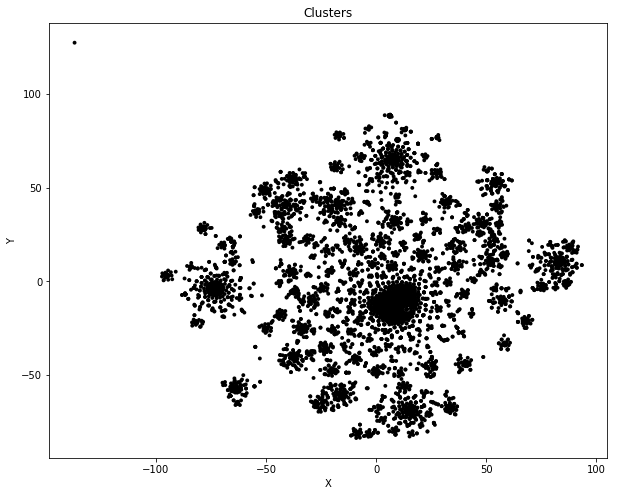

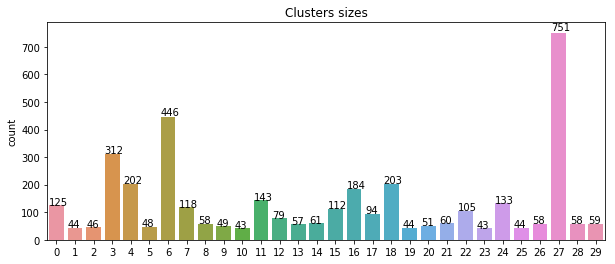

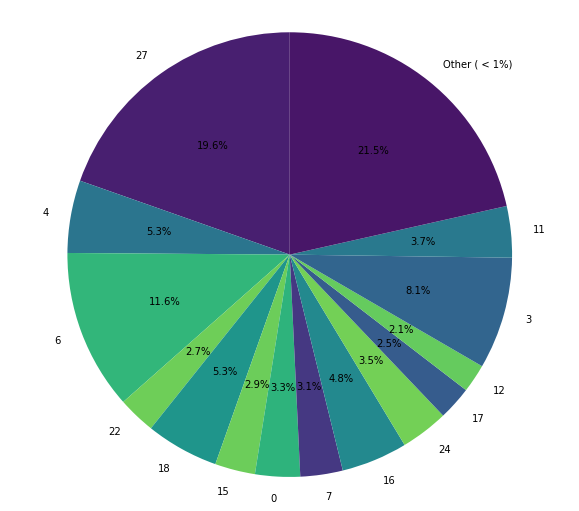

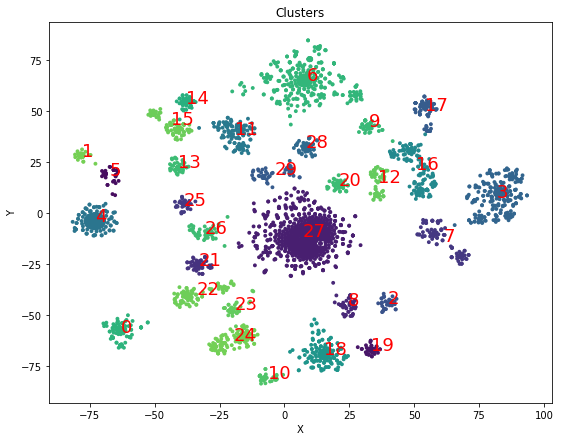

In [11]:
cl.visualize(save_image_to_file=False, show_tsne_res=True)

Визуализируем каждый кластер в виде облака слов. Больший размер шрифта слова означает, что оно чаще встречается в документах данного кластера.

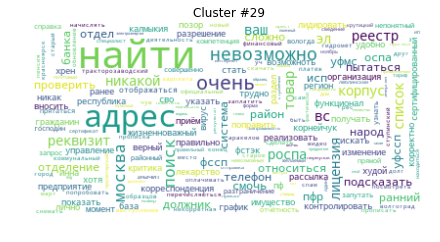

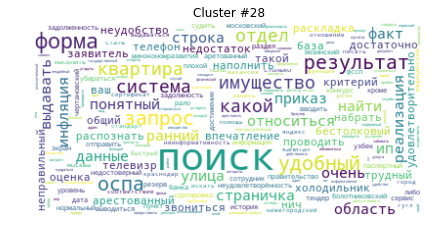

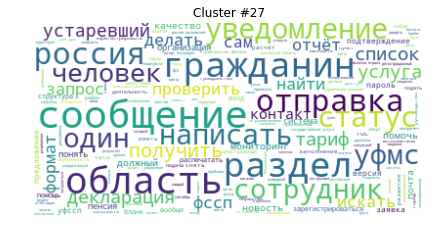

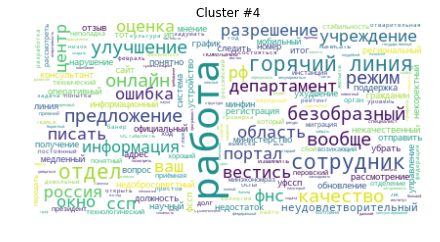

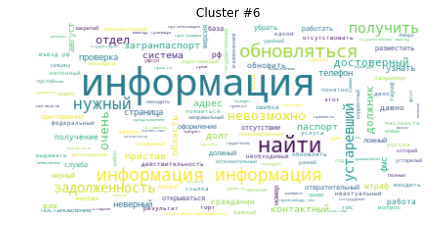

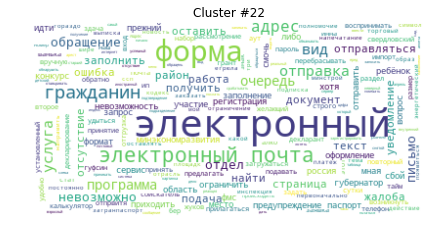

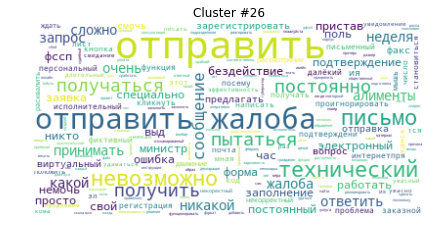

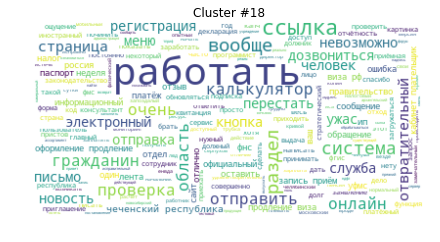

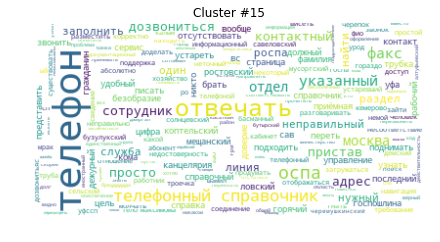

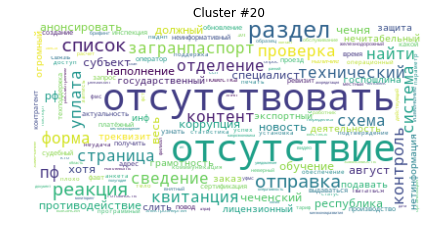

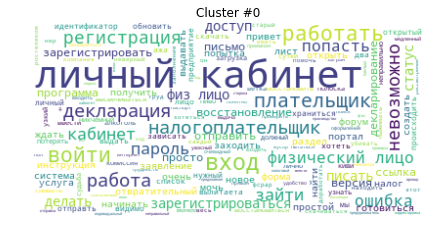

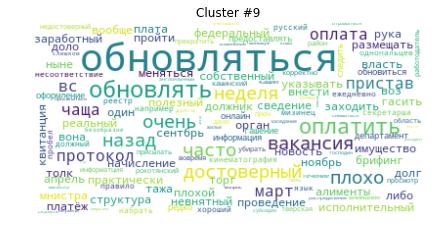

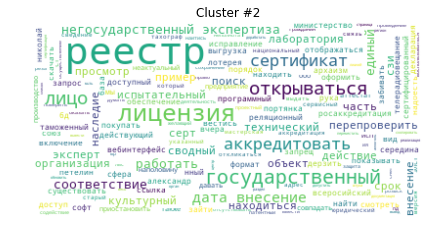

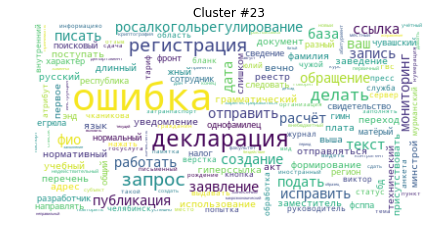

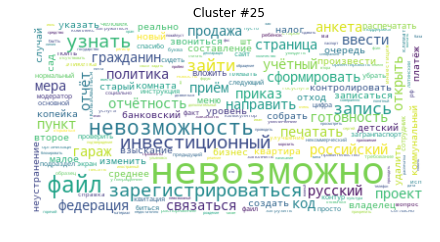

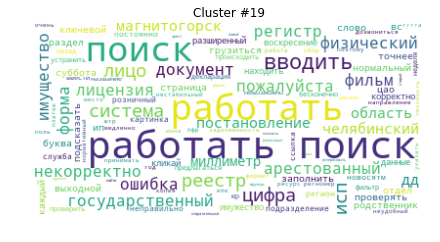

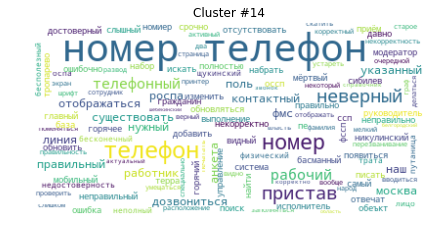

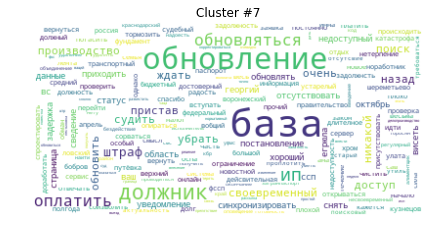

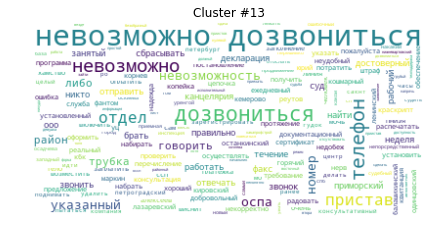

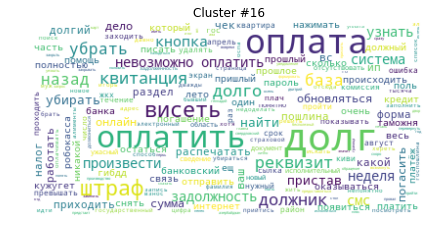

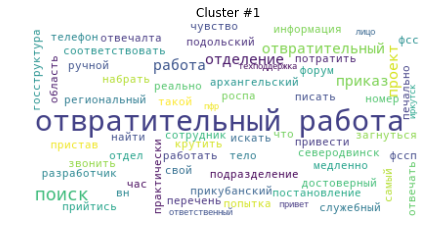

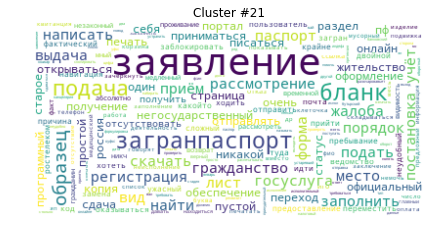

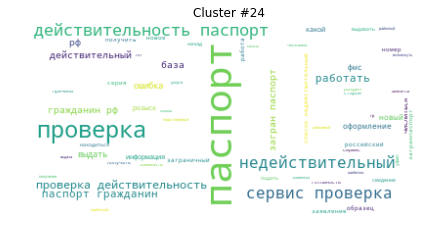

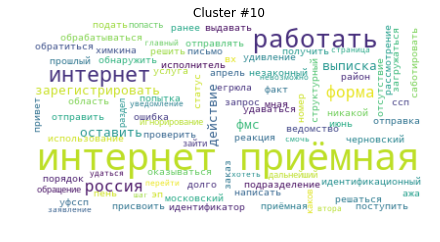

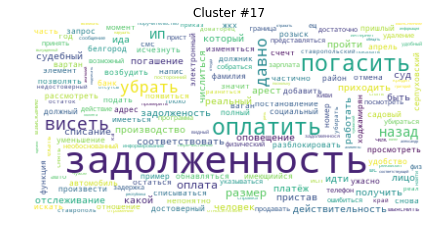

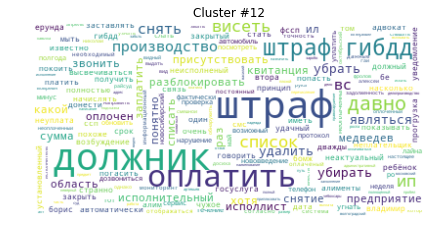

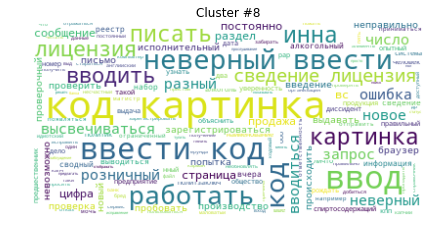

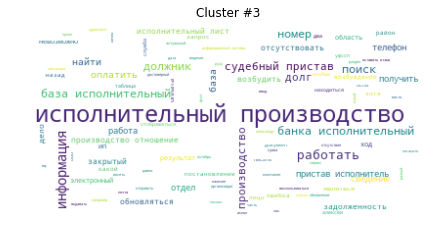

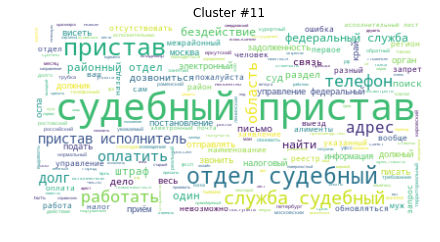

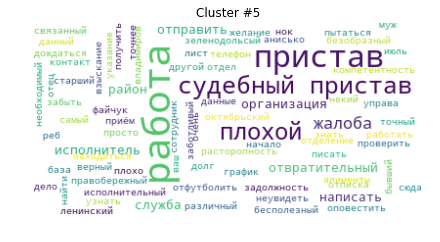

In [12]:
_, clusters_list = cl.get_clusters_rows_tsne()

cl.wordclouds(clusters_list=clusters_list, save_image_to_file=False, save_image_to_db=False)

Сохраняем результаты в CSV файл для последующего использования

In [13]:
clusters = cl.clusters_tsne()

out_df = pd.DataFrame(columns=['cluster', 'text'])
out_df['cluster'] = [row[0] for row in clusters]
out_df['text'] = [row[1] for row in clusters]
out_df.to_csv("resources/train.csv", index=False, sep=';', encoding='windows-1251')

logger.info('Complete clustering')

2019-10-19 22:54:34,962 - feedback-analyzer.clustering - INFO - Complete clustering


Пример полученных кластеров

In [14]:
pd.read_csv('resources/train.csv', sep=';', encoding='windows-1251').head(10)

cluster                                               text
0       29        Трудно найти список жизненноважных лекарств
1       29               Как найти приказ в банке документов?
2       29  Здравствуйте! После обновления сайта не смогла...
3       29                        Позор! На сайте нет адреса!
4       29                 Не смогла найти документ по поиску
5       29                      Ничего не могу найти на сайте
6       29  Не корректно отображается адрес обращения в от...
7       29                               нет почтового адреса
8       29       Не могу найти на сайте график приема граждан
9       29   где найти реквизиты для уплаты взносов в ПФР????